In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from resnet import Resnet4Channel

In [3]:
gpu_device = 1

defaults.device = torch.device(f'cuda:{gpu_device}')
torch.cuda.set_device(gpu_device)

In [4]:
bs = 64

In [5]:
path = Path('/home/haider/data/human_protein_atlas/')

In [6]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [7]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))

In [8]:
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel

In [9]:
src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [10]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [11]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [12]:
test_fnames[:5]

[PosixPath('/home/haider/data/human_protein_atlas/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [13]:
src.add_test(test_fnames, label='0');

In [14]:
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [15]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [16]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [17]:
data = (src.transform((trn_tfms, _), size=224)
        .databunch().normalize(protein_stats))

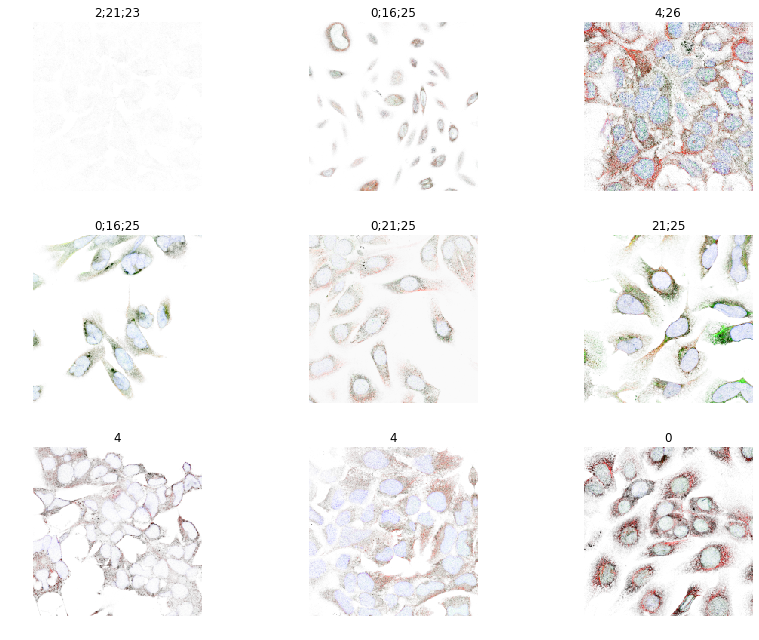

In [18]:
data.show_batch(rows=3, figsize=(12,9))

In [19]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [20]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): 
    # import pdb; pdb.set_trace()  ; m[0] returns the body ; m[0][6] returns the 7th block of the body ; m[1] returns the head; 
    # so it seems this function specifies the points that divides the 3 groups for the differential learning rates
    return (m[0][6],m[1])

In [21]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [22]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


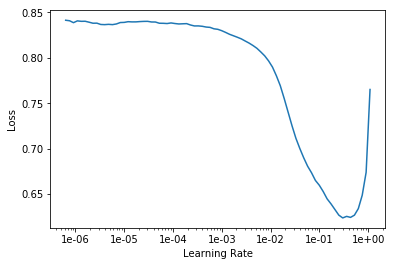

In [24]:
learn.recorder.plot()

In [25]:
lr = 3e-2

In [26]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,fbeta
1,0.140712,0.137885,0.491762
2,0.135242,0.128876,0.562267
3,0.121345,0.189285,0.599726
4,0.109883,0.117632,0.638614
5,0.105846,0.112812,0.646058


In [27]:
learn.save('stage-1-rn50-datablocks')

In [28]:
learn.unfreeze()

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


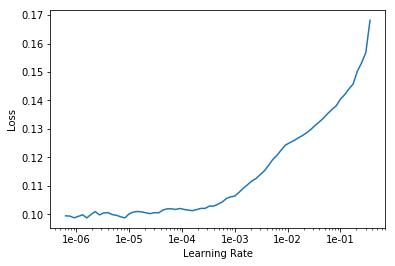

In [30]:
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(15, slice(3e-5, lr/5))

epoch,train_loss,valid_loss,fbeta
1,0.107076,0.110687,0.639665
2,0.107107,0.106425,0.638291
3,0.106963,0.118992,0.604034
4,0.106814,0.219445,0.644425
5,0.103888,0.126575,0.637357
6,0.102458,0.100057,0.664510
7,0.095914,0.095541,0.672963
8,0.093235,0.097399,0.673455
9,0.090836,0.151259,0.674930
10,0.087776,0.103881,0.688379


In [32]:
learn.save('stage-2-rn50')

In [35]:
preds,_ = learn.get_preds(DatasetType.Test)

In [39]:
row = preds[0]

In [40]:
row

tensor([7.2986e-02, 6.9466e-04, 9.9315e-01, 3.1994e-03, 3.2182e-05, 8.0879e-04,
        6.9925e-05, 1.2032e-03, 1.0383e-07, 1.2002e-08, 2.7099e-09, 2.6630e-04,
        6.5402e-04, 5.5848e-05, 1.1863e-05, 8.1733e-07, 8.5827e-04, 5.7181e-06,
        1.7399e-04, 4.2948e-03, 3.7665e-06, 3.8422e-03, 3.1347e-03, 9.1340e-04,
        4.4106e-05, 3.2065e-03, 1.2049e-04, 3.9835e-10])

In [41]:
np.nonzero(row>0.2)[0]

tensor([2])

In [42]:
np.nonzero(row>0.2)

tensor([[2]])

In [54]:
# The chosen thresholds for all labels is set arbitrarly to 0.2

name = 'baseline'

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'subs'/f'{name}.csv', header=True, index=False)

In [55]:
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,23 25


In [56]:
path

PosixPath('/home/haider/data/human_protein_atlas')

In [59]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f {path}/subs/{name}.csv -m "NB of William Horton"

100%|████████████████████████████████████████| 483k/483k [00:09<00:00, 54.8kB/s]
Successfully submitted to Human Protein Atlas Image Classification